<a href="https://colab.research.google.com/github/ErPaan/Trained-with-notebooks-from-udlbook-github.com-udlbook-/blob/main/Notebooks/Chap15/15_1_GAN_Toy_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 15.1: GAN Toy example**

This notebook investigates the GAN toy example as illustrated in figure 15.1 in the book.

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [39]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
# Get a batch of real data.  Our goal is to make data that looks like this.
def get_real_data_batch(n_sample):
  np.random.seed(0)
  x_true = np.random.normal(size=(1,n_sample)) + 7.5
  return x_true

Define our generator.  This takes a standard normally-distributed latent variable $z$ and adds a scalar $\theta$ to this, where $\theta$ is the single parameter of this generative model according to:

\begin{equation}
x_i = z_i + \theta.
\end{equation}

Obviously this model can generate the family of Gaussian distributions with unit variance, but different means.

In [41]:
# This is our generator -- takes the single parameter theta
# of the generative model and generates n samples
def generator(z, theta):
    x_gen = z + theta
    return x_gen

Now, we define our discriminator.  This is a simple logistic regression model (1D linear model passed through sigmoid) that returns the probability that the data is real

In [42]:
# Define our discriminative model

# Logistic sigmoid, maps from [-infty,infty] to [0,1]
def sig(data_in):
  return  1.0 / (1.0+np.exp(-data_in))

# Discriminator computes y
def discriminator(x, phi0, phi1):
  return sig(phi0 + phi1 * x)

In [43]:
# Draws a figure like Figure 15.1a
def draw_data_model(x_real, x_syn, phi0=None, phi1=None):
  fix, ax = plt.subplots();

  for x in x_syn:
    ax.plot([x,x],[0,0.33],color='#f47a60')
  for x in x_real:
    ax.plot([x,x],[0,0.33],color='#7fe7dc')

  if phi0 is not None:
    x_model = np.arange(0,10,0.01)
    y_model = discriminator(x_model, phi0, phi1)
    ax.plot(x_model, y_model,color='#dddddd')
  ax.set_xlim([0,10])
  ax.set_ylim([0,1])


  plt.show()

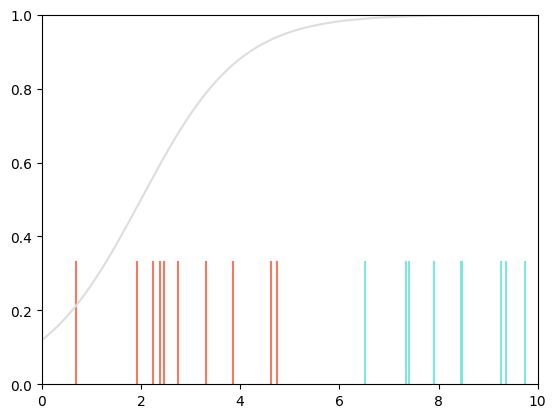

In [44]:
# Get data batch
x_real = get_real_data_batch(10)

# Initialize generator and synthesize a batch of examples
theta = 3.0
np.random.seed(1)
z = np.random.normal(size=(1,10))
x_syn = generator(z, theta)

# Initialize discriminator model
phi0 = -2
phi1 = 1

draw_data_model(x_real, x_syn, phi0, phi1)

You can see that the synthesized (orange) samples don't look much like the real (cyan) ones, and the initial model to discriminate them (gray line represents probability of being real) is pretty bad as well.

Let's deal with the discriminator first.  Let's define the loss

In [45]:
# Discriminator loss
def compute_discriminator_loss(x_real, x_syn, phi0, phi1):

  # TODO -- compute the loss for the discriminator
  # Run the real data and the synthetic data through the discriminator
  # Then use the standard binary cross entropy loss with the y=1 for the real samples
  # and y=0 for the synthesized ones.
  # Replace this line
  prob_real = discriminator(x_real, phi0, phi1)
  prob_syn = discriminator(x_syn, phi0, phi1)
  loss = -np.sum(np.log(prob_real) + np.log(1-prob_syn))


  return loss

In [46]:
# Test the loss
loss = compute_discriminator_loss(x_real, x_syn, phi0, phi1)
print("True Loss = 13.814757170851447, Your loss=", loss )

True Loss = 13.814757170851447, Your loss= 13.814757170851447


In [47]:
# Gradient of loss (cheating, using finite differences)
def compute_discriminator_gradient(x_real, x_syn, phi0, phi1):
  delta = 0.0001;
  loss1 = compute_discriminator_loss(x_real, x_syn, phi0, phi1)
  loss2 = compute_discriminator_loss(x_real, x_syn, phi0+delta, phi1)
  loss3 = compute_discriminator_loss(x_real, x_syn, phi0, phi1+delta)
  dl_dphi0 = (loss2-loss1) / delta
  dl_dphi1 = (loss3-loss1) / delta

  return dl_dphi0, dl_dphi1

# This routine performs gradient descent with the discriminator
def update_discriminator(x_real, x_syn, n_iter, phi0, phi1):

  # Define learning rate
  alpha = 0.01

  # Get derivatives
  print("Initial discriminator loss = ", compute_discriminator_loss(x_real, x_syn, phi0, phi1))
  for iter in range(n_iter):
    # Get gradient
    dl_dphi0, dl_dphi1 = compute_discriminator_gradient(x_real, x_syn, phi0, phi1)
    # Take a gradient step downhill
    phi0 = phi0 - alpha * dl_dphi0 ;
    phi1 = phi1 - alpha * dl_dphi1 ;

  print("Final Discriminator Loss= ", compute_discriminator_loss(x_real, x_syn, phi0, phi1))

  return phi0, phi1

Initial parameters (phi0,phi1) -2 1
Initial discriminator loss =  13.814757170851447
Final Discriminator Loss=  3.732902478030585
Final parameters (phi0,phi1) -3.554083457719191 0.7143290523577974


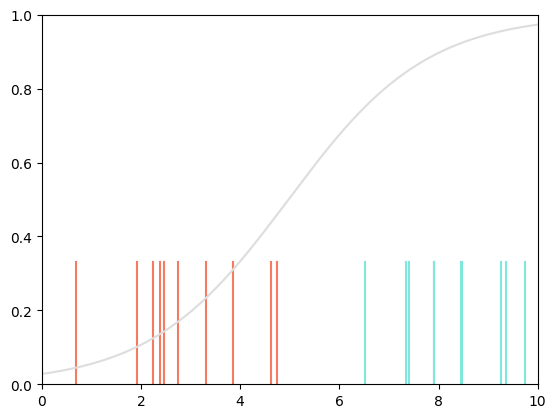

In [48]:
# Let's update the discriminator (sigmoid curve)
n_iter = 100
print("Initial parameters (phi0,phi1)", phi0, phi1)
phi0, phi1 = update_discriminator(x_real, x_syn, n_iter, phi0, phi1)
print("Final parameters (phi0,phi1)", phi0, phi1)
draw_data_model(x_real, x_syn, phi0, phi1)

Now let's update the generator

In [49]:
def compute_generator_loss(z, theta, phi0, phi1):
  # TODO -- Run the generator on the latent variables z with the parameters theta
  # to generate new data x_syn
  # Then run the discriminator on the new data to get the probability of being real
  # The loss is the total negative log probability of being synthesized (i.e. of not being real)
  # Replace this code
  x_syn = generator(z, theta)
  prob = discriminator(x_syn, phi0, phi1)
  loss = -np.sum(np.log(1-prob))


  return loss

In [50]:
# Test generator loss to check you have it correct
loss = compute_generator_loss(z, theta, -2, 1)
print("True Loss = 13.78437035945412, Your loss=", loss )

True Loss = 13.78437035945412, Your loss= 13.78437035945412


In [51]:
def compute_generator_gradient(z, theta, phi0, phi1):
  delta = 0.0001
  loss1 = compute_generator_loss(z,theta, phi0, phi1) ;
  loss2 = compute_generator_loss(z,theta+delta, phi0, phi1) ;
  dl_dtheta = (loss2-loss1)/ delta
  return dl_dtheta

def update_generator(z, theta, n_iter, phi0, phi1):
    # Define learning rate
    alpha = 0.02

    # Get derivatives
    print("Initial generator loss = ", compute_generator_loss(z, theta, phi0, phi1))
    for iter in range(n_iter):
      # Get gradient
      dl_dtheta = compute_generator_gradient(x_real, x_syn, phi0, phi1)
      # Take a gradient step (uphill, since we are trying to make synthesized data less well classified by discriminator)
      theta = theta + alpha * dl_dtheta ;

    print("Final generator loss = ", compute_generator_loss(z, theta, phi0, phi1))
    return theta


Theta before 3.0
Initial generator loss =  2.6027212360722376
Final generator loss =  5.5917426439561595
Theta after 4.387548766601299


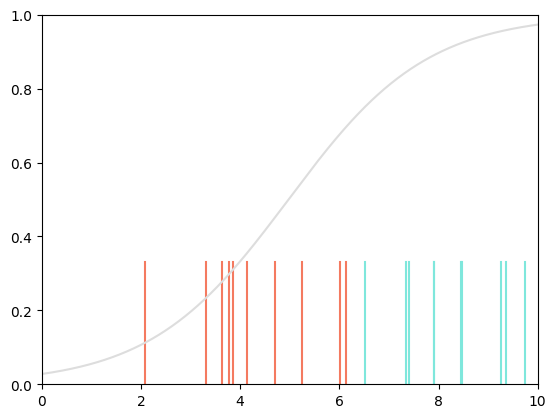

In [52]:
n_iter = 10
theta = 3.0
print("Theta before", theta)
theta = update_generator(z, theta, n_iter, phi0, phi1)
print("Theta after", theta)

x_syn = generator(z,theta)
draw_data_model(x_real, x_syn, phi0, phi1)

Final parameters (phi0,phi1) -2 1


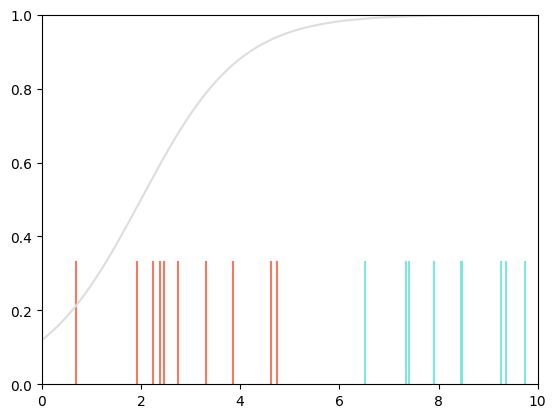

Updating discriminator
Initial discriminator loss =  13.814757170851447
Final Discriminator Loss=  2.31884746352303


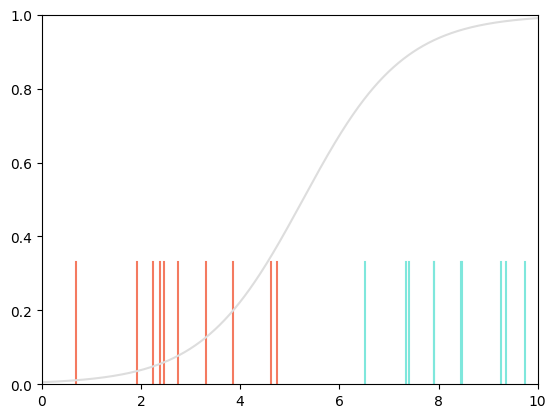

Updating generator
Initial generator loss =  1.5508571592286458
Final generator loss =  2.498619628277297


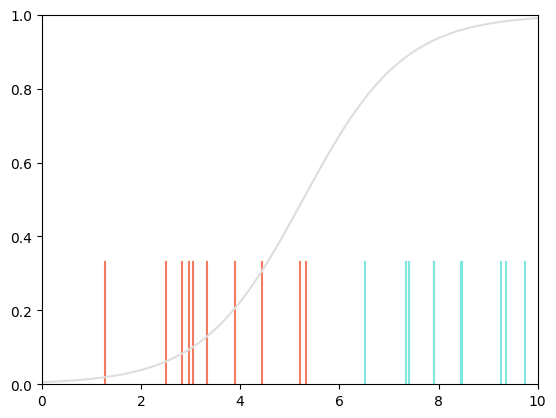

Updating discriminator
Initial discriminator loss =  3.266609932571681
Final Discriminator Loss=  2.258726003543333


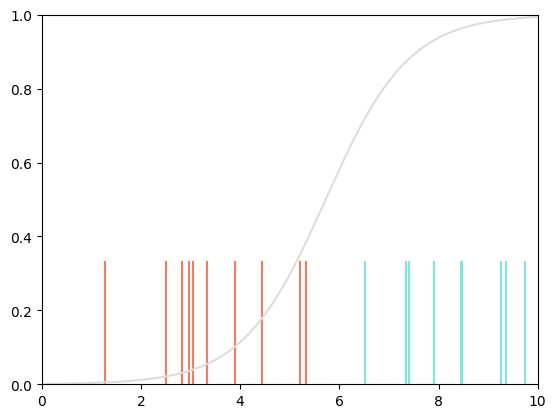

Updating generator
Initial generator loss =  1.4134209576465377
Final generator loss =  2.7862808900584133


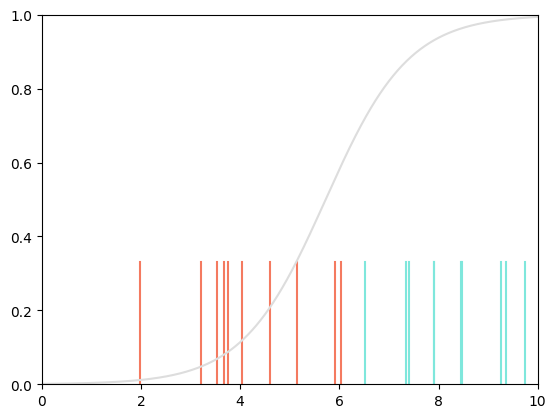

Updating discriminator
Initial discriminator loss =  3.6315859359552087
Final Discriminator Loss=  2.9060238144551263


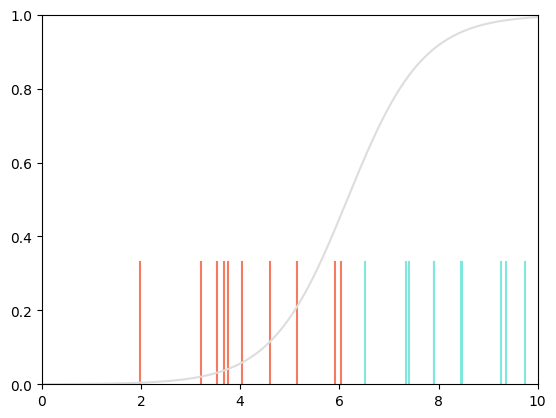

Updating generator
Initial generator loss =  1.7177761016686661
Final generator loss =  3.710564577892173


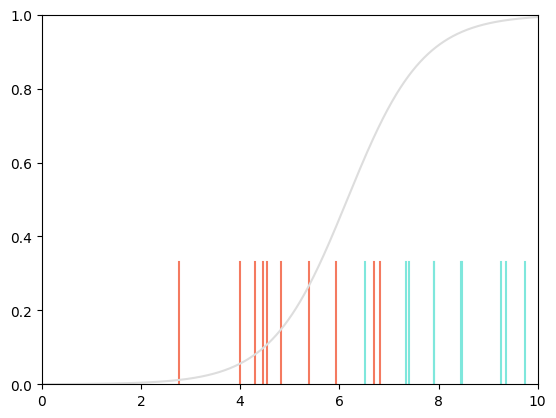

Updating discriminator
Initial discriminator loss =  4.898812290678633
Final Discriminator Loss=  4.261135862039223


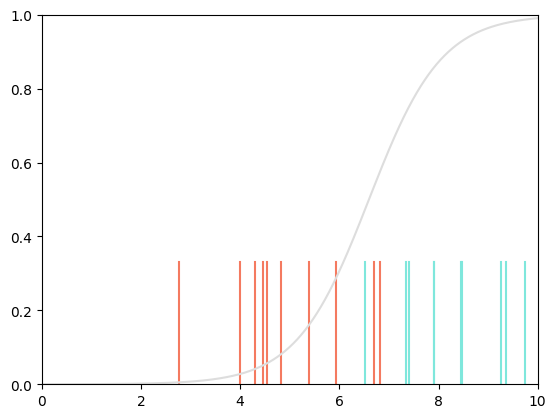

Updating generator
Initial generator loss =  2.4001461125621057
Final generator loss =  5.190633295878723


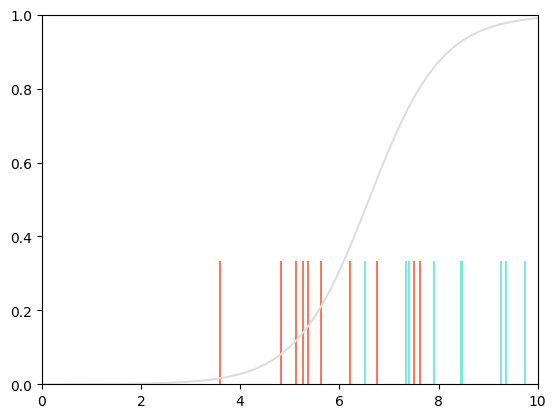

Updating discriminator
Initial discriminator loss =  7.051623045355839
Final Discriminator Loss=  6.493000483461727


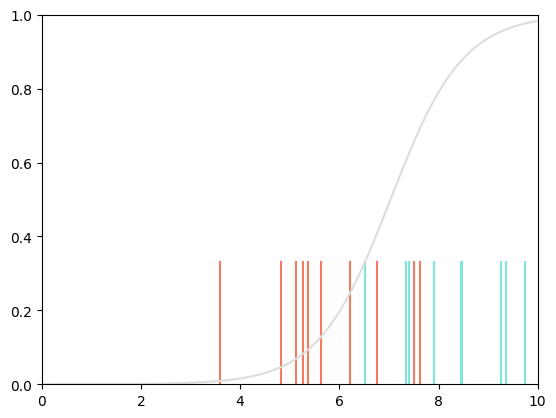

Updating generator
Initial generator loss =  3.5153009141292237
Final generator loss =  7.0931983347325955


In [53]:
# Now let's define a full GAN loop

# Initialize the parameters
theta = 3
phi0 = -2
phi1 = 1

# Number of iterations for updating generator and discriminator
n_iter_discrim = 300
n_iter_gen = 3

print("Final parameters (phi0,phi1)", phi0, phi1)
for c_gan_iter in range(5):

  # Run generator to product synthesized data
  x_syn = generator(z, theta)
  draw_data_model(x_real, x_syn, phi0, phi1)

  # Update the discriminator
  print("Updating discriminator")
  phi0, phi1 = update_discriminator(x_real, x_syn, n_iter_discrim, phi0, phi1)
  draw_data_model(x_real, x_syn, phi0, phi1)

  # Update the generator
  print("Updating generator")
  theta = update_generator(z, theta, n_iter_gen, phi0, phi1)


You can see that the synthesized data (orange) is becoming closer to the true data (cyan).  However, this is extremely unstable -- as you will find if you mess around with the number of iterations of each optimization and the total iterations overall.